In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scqubits as scq
import qutip

# Setup system with two fluxoniums coupled via capacitor

In [19]:
# Define qubits

fqa = scq.Fluxonium(EJ = 4.62,
                   EC = 1.06,
                   EL = 1.09,
                   flux = 0.5,
                   cutoff = 110)


fqb = scq.Fluxonium(EJ = 5.05,
                   EC =1.03,
                   EL = 1.88,
                   flux = 0.5,
                   cutoff = 110)

# Define interaction operators / strength

g1=0.350
n_a=fqa.matrixelement_table("n_operator",evals_count=fqa.truncated_dim)
n_b=fqb.matrixelement_table("n_operator",evals_count=fqb.truncated_dim)

# Build composite Hilbert space
hs=scq.HilbertSpace([fqa, fqb])
hs.add_interaction(
    g=g1,
    op1=(fqa.n_operator(), fqa),
    op2=(fqb.n_operator(), fqb)
)
hs.generate_lookup()

# Get operators, states, and energies in composite hilbert space
H0=2*pi*hs.hamiltonian()
na=scq.identity_wrap(n_a, fqa,[fqa,fqb],op_in_eigenbasis=True)
nb=scq.identity_wrap(n_b, fqb,[fqa,fqb],op_in_eigenbasis=True)
ens,evs=H0.eigenstates()

# Get indices of dressed qubit levels
ix00=hs.lookup.dressed_index((0,0))
ix10=hs.lookup.dressed_index((1,0))
ix01=hs.lookup.dressed_index((0,1))
ix11=hs.lookup.dressed_index((1,1))
ix03=hs.lookup.dressed_index((0,3))

# Look at relevant matrix elements

In [20]:
na.matrix_element(evs[ix00],evs[ix01])

-0.0016379942385420729j

In [21]:
na.matrix_element(evs[ix00],evs[ix10])

0.13740790153130253j

In [22]:
na.matrix_element(evs[ix00],evs[ix03])

0.01422306720709558j

In [24]:
((ens[ix11]-ens[ix10]) - (ens[ix01]-ens[ix00]))/(2*pi) #ZZ shift

-0.0017691645389581875

# Qutip simulation of CX 

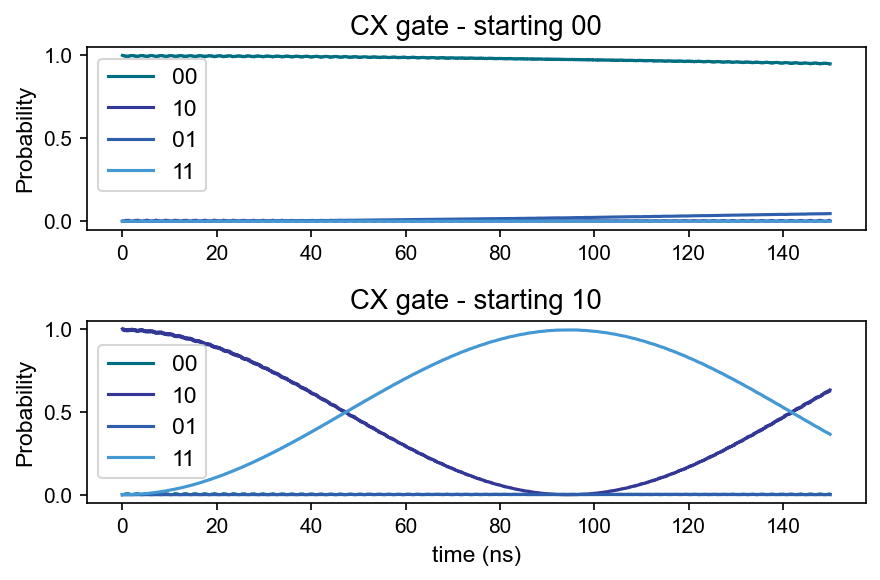

In [27]:
# Specify arguments and time steps
wa=ens[ix10]-ens[ix00]
wb=ens[ix11]-ens[ix10]
beta=2*pi*.3
myargs={'wb':wb, 'wa':wa, 'beta':beta}

tpts = arange(0,150,0.2/wb)

# Define the initial states of the qubit
psi00 = evs[hs.lookup.dressed_index((0,0))]
psi10 = evs[hs.lookup.dressed_index((1,0))]
        
H= [ H0 , [na,"beta * cos(wb * t)"]]

c_ops = []

#expectation values to return (number operator for each mode)    
expects=[evs[ix].proj() for ix in [ix00, ix10,ix01,ix11]]
labels=('00','10','01','11')

# Calculate evolution for control qubit in 0 and in 1
results0 = qutip.mesolve(H, psi00, tpts, c_ops, expects ,args=myargs)
results1 = qutip.mesolve(H, psi10, tpts, c_ops, expects ,args=myargs)

# Plot results
subplot(211, title="CX gate - starting 00", ylabel='Probability')
for ex,label in zip(results0.expect,labels):
    plot(tpts, ex,label=label)
legend()
subplot(212, title="CX gate - starting 10", ylabel='Probability',xlabel='time (ns)')
for ex,label in zip(results1.expect,labels):
    plot(tpts, ex,label=label)
legend()
tight_layout()